In [1]:
import numpy as np

from traffic.core import Traffic
from matplotlib import pyplot as plt
from functions.data_filtering import filter_flights, complete_flights_filter
from functions.data_processing import get_takeoff_and_landing_directions
from functions.data_loading import get_data_range
from datetime import datetime

In [2]:
origin = "bergen"
destination = "oslo"
flights: Traffic = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1))

In [3]:
filtered_flights = filter_flights(complete_flights_filter(origin, destination), flights)

In [4]:
filtered_flights

,,count
icao24,callsign,
478dd9,AKK2,63482
4ac958,SAS252,35901
47c1c6,BNOG,34775
47875a,NOZ605,34701
47a31a,NOZ605,27835
4784a1,SAS252,26647
47885f,BNON,26471
47875a,NOZ601,26361
47a05e,NOZ605,25294


In [5]:
filtered_flights[0].map_leaflet()

Map(center=[60.400553709320306, 8.261436769685307], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [6]:
directions = list(get_takeoff_and_landing_directions(filtered_flights))
start = [start for start, _ in directions]
end = [end for _, end in directions] 

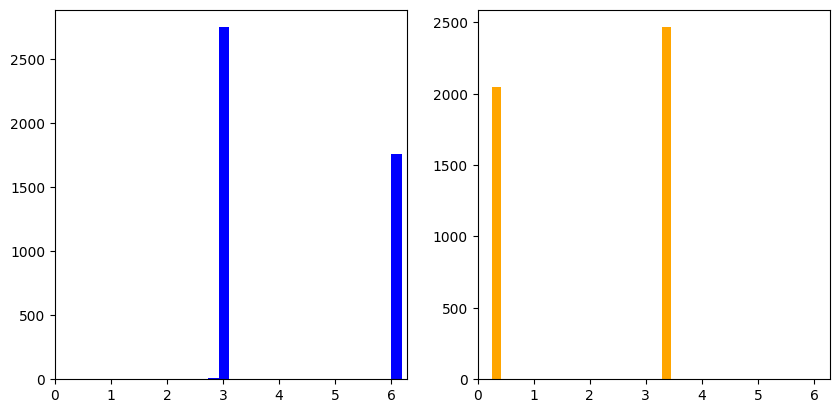

In [7]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(start, bins=20, color="blue")
ax[0].set_xlim([0, 2*np.pi])
ax[1].hist(end, bins=20, color="orange")
ax[1].set_xlim([0, 2*np.pi])
fig.set_figwidth(10)
plt.show()

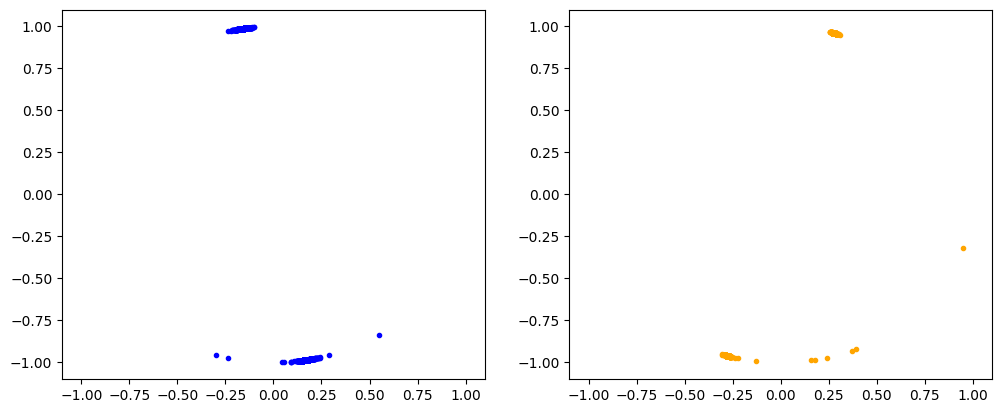

In [10]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(np.sin(start), np.cos(start), '.', color="blue")
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[1].plot(np.sin(end), np.cos(end), '.', color="orange")
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
fig.set_figwidth(12)
plt.show()

In [11]:
first_30_sec = filtered_flights[200].last('30 sec')

direction = first_30_sec.data.get(['heading']).median().values[0]
print(direction)
first_30_sec.map_leaflet(zoom=13)


196.15194071463094


Map(center=[60.23949233232918, 11.105219272557148], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [14]:
i = 0
for start, end in directions:
    if np.sin(end) > 0.75:
        print(i)
    i += 1

2867


In [23]:
filtered_flights[2867].last('5 sec').data

,timestamp,icao24,latitude,longitude,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,serials,hour
15836040,2023-12-18 17:32:24+00:00,47c39c,60.227796,11.098448,48.193272,196.113418,-2.27584,BNO3T,False,False,False,None,373.38,327.66,1.702921e+09,1.702921e+09,[-1408233889],2023-12-18 17:00:00+00:00
15836041,2023-12-18 17:32:25+00:00,47c39c,60.227796,11.098448,48.193272,196.113418,-2.27584,BNO3T,False,False,False,None,373.38,327.66,1.702921e+09,1.702921e+09,[-1408233889],2023-12-18 17:00:00+00:00
15836042,2023-12-18 17:32:26+00:00,47c39c,60.227188,11.098086,48.338577,196.699244,-2.27584,BNO3T,False,False,False,None,373.38,327.66,1.702921e+09,1.702921e+09,[-1408233889],2023-12-18 17:00:00+00:00
15836043,2023-12-18 17:32:27+00:00,47c39c,60.226958,11.097957,48.338577,196.699244,-2.27584,BNO3T,False,False,False,None,373.38,327.66,1.702921e+09,1.702921e+09,[-1408233889],2023-12-18 17:00:00+00:00
15836044,2023-12-18 17:32:28+00:00,47c39c,60.226958,11.097957,48.831549,196.525796,-1.95072,BNO3T,False,False,False,None,373.38,327.66,1.702921e+09,1.702921e+09,[-1408233889],2023-12-18 17:00:00+00:00


In [25]:
np.sin(196.113418 * np.pi / 180)

-0.2775396489124202

In [39]:
import math
for flight in filtered_flights:
    direction = flight.last('5 sec').data.get(['heading']).median().values[0]
    if np.sin(direction * math.pi / 180) > 0.75:
        print(flight)